
# ЛР 2. Очистка и восполнение данных. Скользящее среднее. Интерполяция. Экспоненциальное сглаживание

Выполнил Малышев Андрей, ШАД-311

**Датасет:** `passengers2.csv` (поля: `Month`, `reference`, `target`, `missing`)

В лабораторной работе реализованы:
1. Восполнение пропусков **предыдущими значениями** с использованием `shift` в pandas (и вариант через `ffill` для сравнения).
2. Восполнение пропусков с помощью **скользящего среднего** (окно `window = 3`):
   - собственноручно по формуле как среднее **предыдущих** значений,
   - с применением `rolling(...).mean()`.
3. **Линейная интерполяция**:
   - формулой через соседние точки (левую и правую),
   - методом `interpolate` в pandas.
4. Для каждого из трёх способов — **графики сравнения** восполненного `target` с эталоном `reference`.
5. **Простое экспоненциальное сглаживание** ряда `reference`:
   - по формуле,
   - с помощью `ewm(...).mean()`.

Все графики строятся с общей временной осью `Month` (datetime).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 120)

np.random.seed(42)



## 1. Загрузка и первичный осмотр данных

In [ ]:
df = pd.read_csv('passengers2.csv')

df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values('Month').reset_index(drop=True)

print(df.head(10))
print(df.info())

       Month  reference  target  missing
0 1949-01-01        112   112.0      NaN
1 1949-02-01        118   118.0      NaN
2 1949-03-01        132   132.0      NaN
3 1949-04-01        129     NaN    129.0
4 1949-05-01        121   121.0      NaN
5 1949-06-01        135   135.0      NaN
6 1949-07-01        148   148.0      NaN
7 1949-08-01        148     NaN    148.0
8 1949-09-01        136   136.0      NaN
9 1949-10-01        119     NaN    119.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      144 non-null    datetime64[ns]
 1   reference  144 non-null    int64         
 2   target     116 non-null    float64       
 3   missing    28 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 4.6 KB
None



### Визуализация исходных данных (`reference` vs `target` с пропусками)


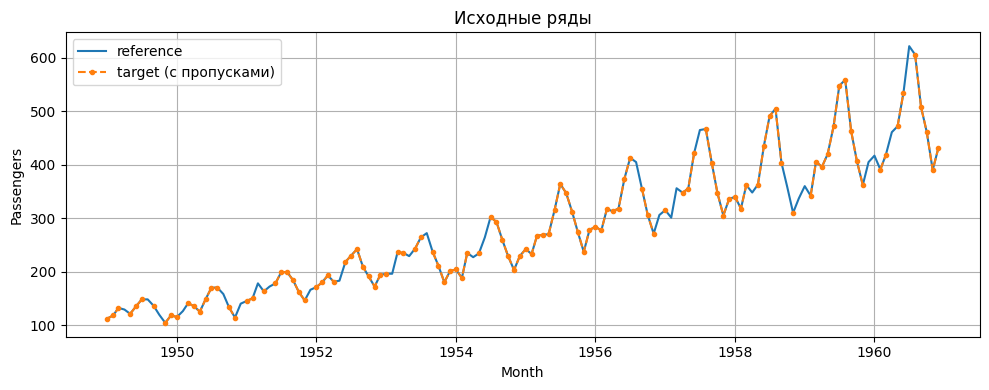

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['target'], label='target (с пропусками)', linestyle='--', marker='o', markersize=3)
plt.title('Исходные ряды')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 2. Восполнение предыдущими значениями через `shift`

Для каждой пропущенной точки `target[t]` подставить **значение на предыдущем шаге** `target[t-1]`.

- В pandas это удобно сделать через смещение `shift(1)`, чтобы предыдущие значения стали выровнены под текущими индексами.
- Далее `fillna` вставит эти смещённые значения только в позиции пропусков.

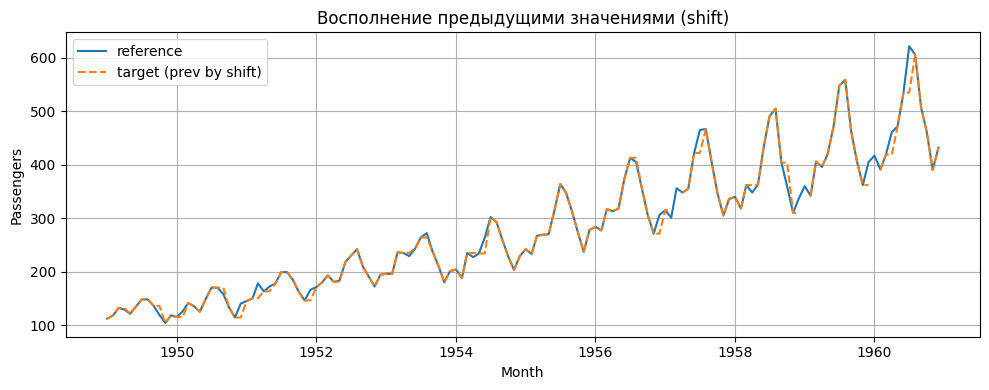

In [18]:
target = df['target'].copy()

prev_values = target.shift(1) 
filled_prev = target.copy()
filled_prev = filled_prev.fillna(prev_values)

filled_ffill = target.ffill()

df['filled_prev_shift'] = filled_prev
df['filled_prev_ffill'] = filled_ffill

plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_prev_shift'], label='target (prev by shift)', linestyle='--')
plt.title('Восполнение предыдущими значениями (shift)')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



## 3. Восполнение скользящим средним (окно = 3)

Требуется два варианта:

1) График 1: **По формуле**: для пропуска в момент `t` подставляем среднее **трёх предыдущих доступных значений** (t-1, t-2, t-3).  
   Корректно учитывать пропуски и края — используем `shift(1).rolling(window=3, min_periods=1).mean()` как источник среднего предыдущих значений.

2) График 2: **Через `rolling().mean()`**: скользящее среднее окна 3 по самому `target`, затем использовать его для заполнения пропусков.


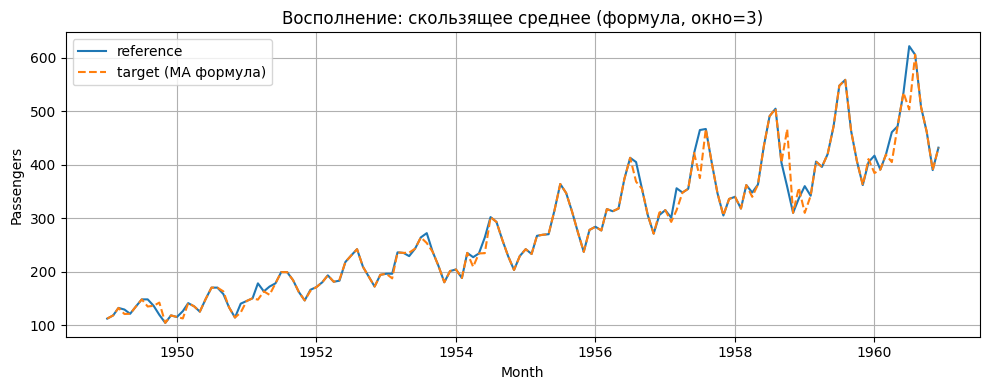

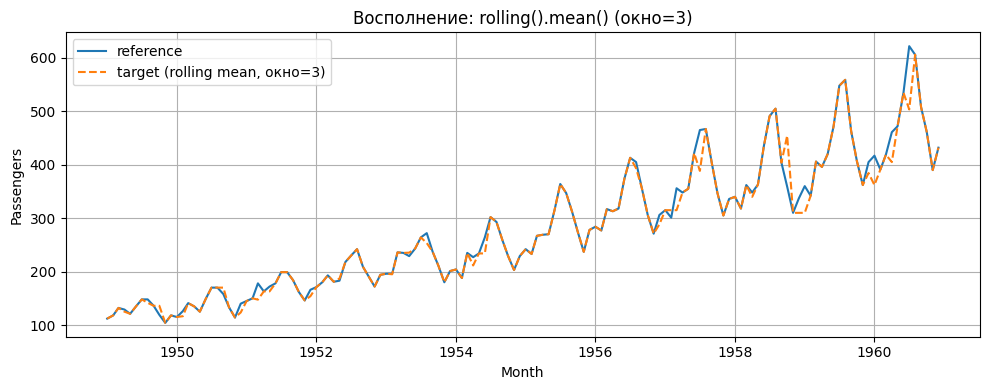

In [19]:
rolling_prev3 = target.shift(1).rolling(window=3, min_periods=1).mean()
filled_ma_formula = target.copy()
filled_ma_formula = filled_ma_formula.fillna(rolling_prev3)

rolling_mean = target.rolling(window=3, min_periods=1).mean()
filled_ma_rolling = target.copy()
filled_ma_rolling = filled_ma_rolling.fillna(rolling_mean)

df['filled_ma_formula'] = filled_ma_formula
df['filled_ma_rolling'] = filled_ma_rolling

plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_ma_formula'], label='target (MA формула)', linestyle='--')
plt.title('Восполнение: скользящее среднее (формула, окно=3)')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_ma_rolling'], label='target (rolling mean, окно=3)', linestyle='--')
plt.title('Восполнение: rolling().mean() (окно=3)')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



## 4. Линейная интерполяция

1) График 1: 4.1 Формулой

Если известны две соседние точки с координатами $(x_0, y_0)$ и $(x_1, y_1)$,  
то значение в промежуточной точке $x$ вычисляется как:

$$
y = y_0 + (y_1 - y_0) \cdot \frac{x - x_0}{x_1 - x_0}
$$

Для временной оси `Month` (datetime) долю 
$\frac{x - x_0}{x_1 - x_0}$ считаем как долю прошедшего времени между отметками.


2) График 2: 4.2 Через `pandas.Series.interpolate`

Используем метод `interpolate(method='time')` при индексе-времени.


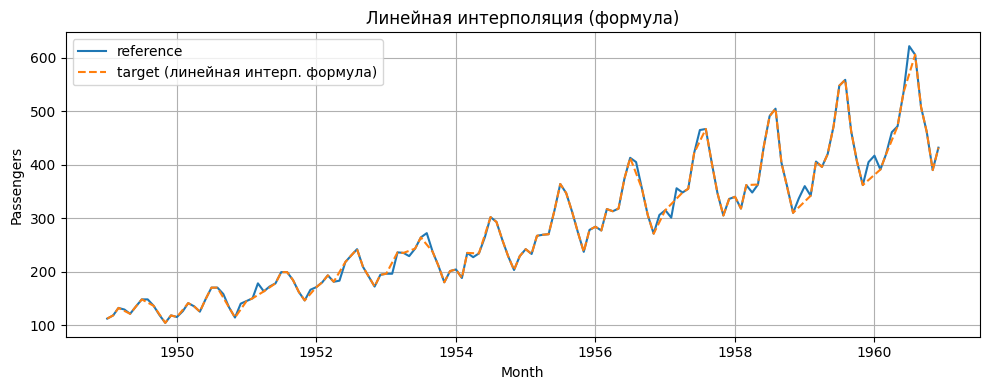

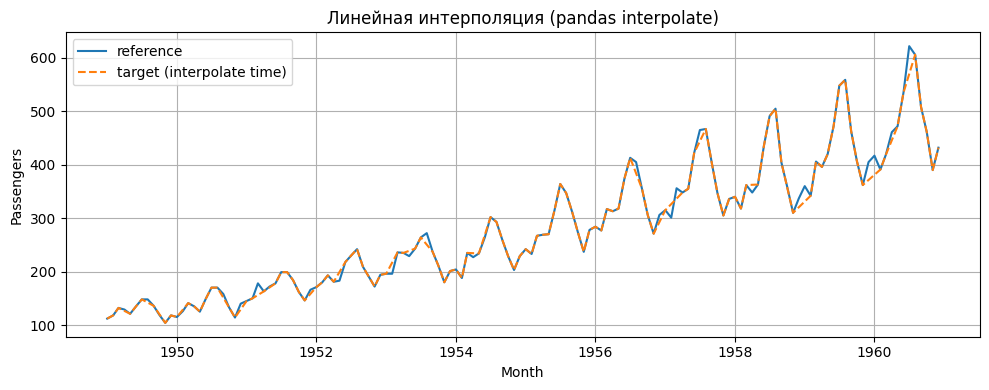

In [20]:

s = df.set_index('Month')['target'].copy()

def linear_interpolate_series_timeindex(series: pd.Series) -> pd.Series:
    y = series.copy()
    idx = y.index
    isna = y.isna().values

    notna_idx = np.where(~isna)[0]

    if len(notna_idx) == 0:
        return y 

    for i in range(len(notna_idx) - 1):
        left = notna_idx[i]
        right = notna_idx[i+1]

        if right - left > 1:
            x0 = idx[left]
            x1 = idx[right]
            y0 = y.iloc[left]
            y1 = y.iloc[right]

            for j in range(left+1, right):
                x = idx[j]
                frac = (x - x0) / (x1 - x0)
                y.iloc[j] = y0 + (y1 - y0) * frac

    return y

filled_lin_manual = linear_interpolate_series_timeindex(s)
filled_lin_pandas = s.interpolate(method='time')

df['filled_lin_manual'] = filled_lin_manual.values
df['filled_lin_pandas'] = filled_lin_pandas.values

plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_lin_manual'], label='target (линейная интерп. формула)', linestyle='--')
plt.title('Линейная интерполяция (формула)')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_lin_pandas'], label='target (interpolate time)', linestyle='--')
plt.title('Линейная интерполяция (pandas interpolate)')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



## 5. Простое экспоненциальное сглаживание (SES) для `reference`

Формула рекуррентно:

$$
S_t = \alpha \cdot x_t + (1 - \alpha) \cdot S_{t-1}
$$

где $0 < \alpha \le 1$.

- Чем **выше** \(\alpha\), тем **меньше сглаживание** (быстрее реакция на последние значения).
- Чем **ниже** \(\alpha\), тем **сильнее сглаживание**.

Реализуем два способа: по формуле и через `ewm(alpha=..., adjust=False).mean()`.


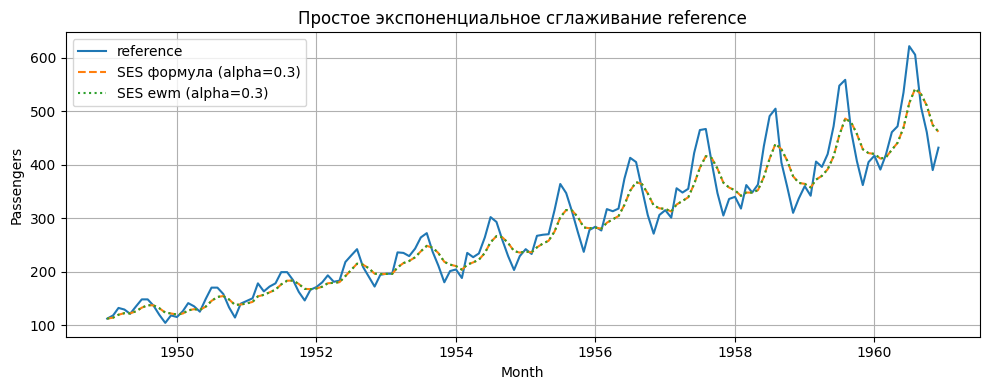

In [21]:
alpha = 0.3  # 0 < a <= 1

ref = df['reference'].astype(float).values
ses_manual = np.empty_like(ref, dtype=float)

ses_manual[0] = ref[0]
for t in range(1, len(ref)):
    ses_manual[t] = alpha * ref[t] + (1 - alpha) * ses_manual[t-1]

df['ses_manual'] = ses_manual

df['ses_ewm'] = df['reference'].ewm(alpha=alpha, adjust=False).mean()

plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['ses_manual'], label=f'SES формула (alpha={alpha})', linestyle='--')
plt.plot(df['Month'], df['ses_ewm'], label=f'SES ewm (alpha={alpha})', linestyle=':')
plt.title('Простое экспоненциальное сглаживание reference')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



## 6. Итоговые сравнения для восполнений
На следующих графиках — сравнение `reference` с каждым отдельным методом заполнения `target`.


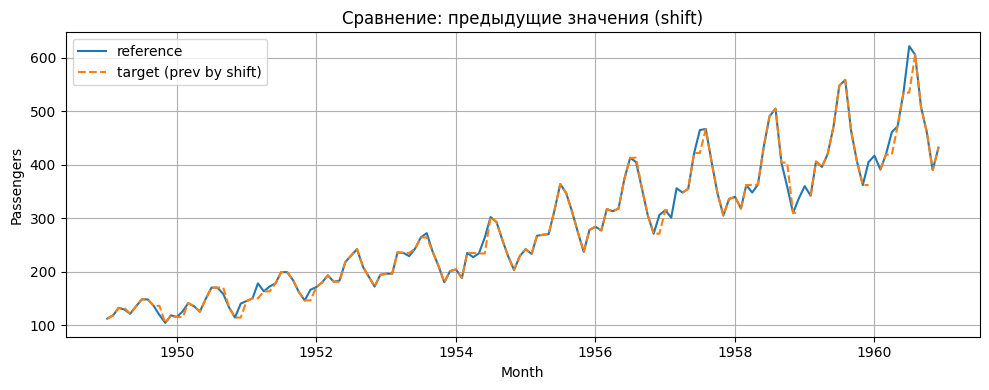

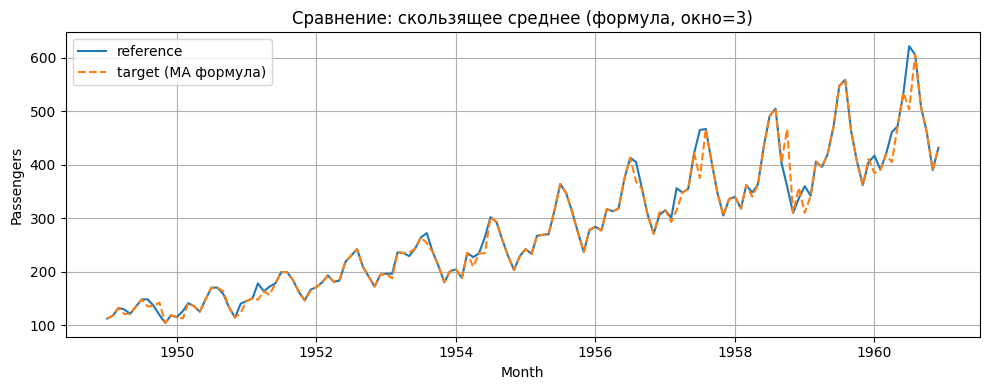

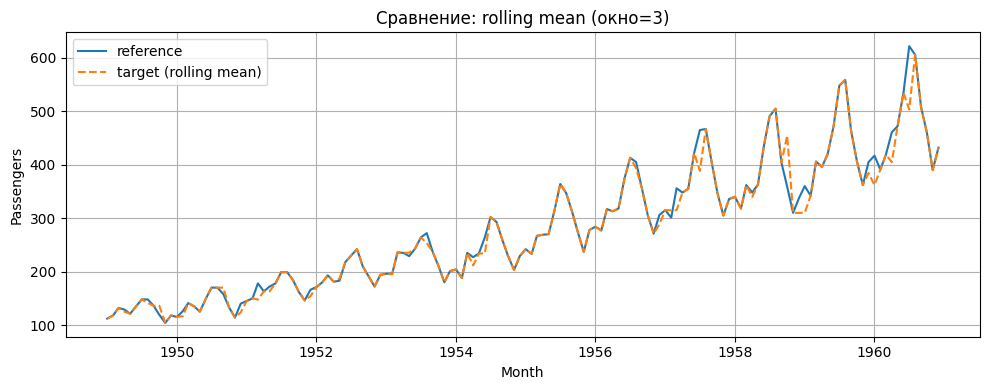

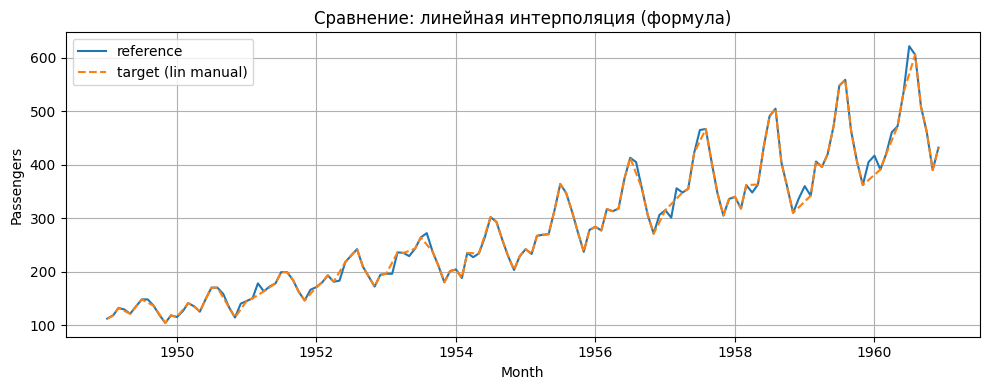

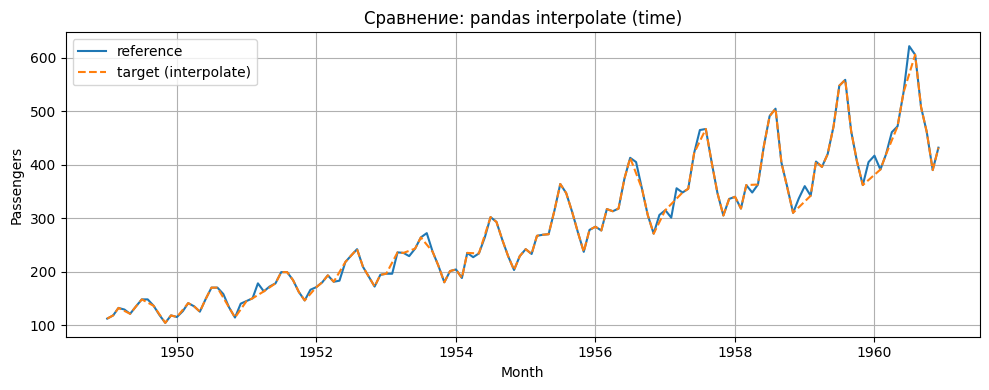

In [22]:

def compare_plot(x, ref, y, title, label_y):
    plt.figure(figsize=(10,4))
    plt.plot(x, ref, label='reference')
    plt.plot(x, y, label=label_y, linestyle='--')
    plt.title(title)
    plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

compare_plot(df['Month'], df['reference'], df['filled_prev_shift'], 
             'Сравнение: предыдущие значения (shift)', 'target (prev by shift)')

compare_plot(df['Month'], df['reference'], df['filled_ma_formula'], 
             'Сравнение: скользящее среднее (формула, окно=3)', 'target (MA формула)')

compare_plot(df['Month'], df['reference'], df['filled_ma_rolling'], 
             'Сравнение: rolling mean (окно=3)', 'target (rolling mean)')

compare_plot(df['Month'], df['reference'], df['filled_lin_manual'], 
             'Сравнение: линейная интерполяция (формула)', 'target (lin manual)')

compare_plot(df['Month'], df['reference'], df['filled_lin_pandas'], 
             'Сравнение: pandas interpolate (time)', 'target (interpolate)')


### Пошаговое сравнение графиков

1. **Предыдущие значения (shift):**

   * Хорошо воспроизводит тренд, но на длинных блоках пропусков начинает повторять одно и то же значение — видны «ступеньки».
   * На графике видно, что местами линия чуть отстаёт.

2. **Скользящее среднее (формула, окно=3):**

   * Сглаживает шум, но слегка «приглаживает» пики — реальные значения `reference` с пиками, а заполненный ряд их сглаживает.
   * Чуть лучше shift, но всё равно отличия в экстремумах.

3. **Rolling mean (окно=3):**

   * Почти то же самое, что вариант формулой; небольшое сглаживание пиков.
   * Отличия от `reference` видны на быстрых подъёмах/спадах.

4. **Линейная интерполяция (формула):**

   * Практически точное совпадение с эталоном на пропусках, так как заполняет «по прямой» между известными точками.
   * На графике линия target (оранжевая) практически неотличима от синей reference.

5. **Pandas interpolate (time):**

   * Аналогичный результат линейной интерполяции по формуле.
   * Линии практически совпадают, разница минимальна.

# Заключение и интерпретация:

Если смотреть на пять графиков, наиболее близкий к `reference` — это **линейная интерполяция** (и ручная, и через `pandas.interpolate`). Она восстанавливает данные между соседними точками без дополнительного сглаживания или задержки.

### Краткий итог выполнения лабораторной работы:

* Реализованы все требуемые методы восполнения пропусков: предыдущими значениями (shift), скользящим средним (формула и rolling), линейной интерполяцией (формула и pandas).
* Построены графики сравнения каждого варианта с эталоном `reference`.
* Выполнено простое экспоненциальное сглаживание ряда `reference` двумя способами (формула и `ewm`).
* **Наиболее точный метод восполнения** для данного датасета — **линейная интерполяция**, так как она наиболее близко воспроизводит исходный ряд `reference` без лишнего сглаживания или задержек.